COPYRIGHT NOTICE
In the name of Christ our Lord be blessed. We, Joshuah Rainstar(joshuah.rainstar@gmail.com), do claim copyright to this code, or software, and associated documentation, as our work in the year 2025 Anno Domini, reserving all rights and assigning them in accordance with the following license terms:

1. Permission is by our authority and with this statement granted, to any person or artificial intelligence without limitation or restriction to examine, analyze, read, dissect, translate, use, modify, and distribute the aforementioned copyrighted items, subject to the following conditions:
2. This license must be included in full with any copies or works containing substantial portions of the copyrighted items.
3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.


THE COPYRIGHTED ITEMS ARE PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE COPYRIGHTED ITEMS OR THEIR USE OR ANY OTHER CIRCUMSTANCES CONCERNING THEM.


this is an experimental model intended to elucidate possible mechanics for attention across sequences in addition to tokenwise. it is reasonably fast and efficient. conceptually, the design was envisioned by me and coded through refinement with OpenAI Codex Orion One and chatgpt. i find that if i cant understand a thing, however clever it is- its wrong.
so, this is largely a from-scratch along aligned principles. 

you are advised in life to apply a similar practice. nothing good comes of shit you dont comprehend.

"hierarchical multi-scale transformer with MoE-like  selection"

my own fucking activation function

my own fucking loss method borrowing from harmonic loss but using student-t distribution 9!

XOR from  Two-argument activation functions learn soft XOR operations like cortical neurons
https://arxiv.org/abs/2110.06871note that my implementation is a differential XOR for backprop capability
motivation: little bit of internal reasoning maybe? Impact: slows down convergence somewhat

WOLF optimizer experimental by me, it may not beat adam but it is simpler than adam, closer to SGD with some smoothing of integration
impact: speeds up convergence somewhat for early iterations and will not NAN from high LR.
probable benefit- switch optimizers after model drops. could be good for bigger models.. maybe

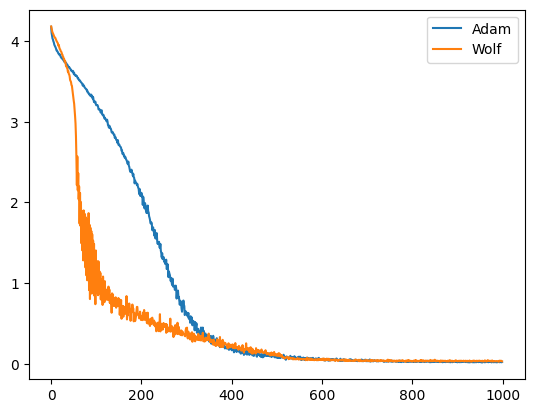
m 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
import math
import requests

In [93]:
from torch.optim.optimizer import Optimizer
class Wolf(Optimizer):
    """Implements Wolf algorithm."""
    def __init__(self, params, lr=0.25, betas=(0.9, 0.999), eps=1e-8):
        # Define default parameters
        defaults = dict(lr=lr, betas=betas, eps=eps)
        self.lr = lr
        # Initialize the parent Optimizer class first
        super().__init__(params, defaults)
        # Constants specific to Wolf
        # Initialize state for each parameter
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['p'] = torch.zeros_like(p)  # Second moment estimate


    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step and adjusts dropout in transformer blocks."""
        etcerta = 0.367879441  # Constant used in update rule
        et = 1 - etcerta
    
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
    
        # Iterate over parameter groups.
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                grad = p.grad
    
                #  AMP Compatibility: Check for NaN or Inf in gradients
                if torch.isnan(grad).any() or torch.isinf(grad).any():
                    print("Skipping parameter update due to NaN/Inf gradient.")
                    continue  # Skip this update if the gradient has NaN or Inf
    
                state = self.state[p]
                exp_avg = state['p']
    
                # Compute update and update second moment-like state.
                update = exp_avg * et + grad * etcerta
                state['p'] = exp_avg * et + update * etcerta
    
                # Compute sign agreement between update and gradient.
                sign_agreement = torch.sign(update) * torch.sign(grad)
    
                # Where the signs agree (mask is True), update the parameter.
                mask = (sign_agreement > 0)
                adaptive_alpha = group.get('lr', self.lr)
                p.data = torch.where(mask, p.data - adaptive_alpha * update, p.data)
    
                # AMP Compatibility: Ensure a step counter is updated
                state['step'] = state.get('step', 0) + 1  # Track optimization steps
    
        return loss

   
def student_t_unembedding(hidden_states, unembedding, df=2.718281828459, eps=1e-9, placeholder_idx=None):
    """
    Student's t-based unembedding with optional placeholder modification.
    
    Arguments:
      hidden_states: (B, S, D)  => model’s output embeddings (hidden state)
      unembedding:   (D, V)    => learnable "word vectors" (unembedding matrix)
      df (float): degrees of freedom for the Student's t distribution
      eps (float): numerical epsilon to avoid log(0) and div-by-zero
      placeholder_idx (int, optional): if provided, indicates the column in the unembedding
          corresponding to the placeholder token. The distances for that token will be adjusted 
          using an adaptive noise factor.
    
    Returns:
      p: (B, S, V)  probability distribution over V vocabulary tokens.
    """
    B, S, D = hidden_states.shape
    V = unembedding.shape[1]

    # Expand hidden => (B, S, 1, D)
    x_expanded = hidden_states.unsqueeze(2)
    # Expand unembedding => (1, 1, V, D)
    w_expanded = unembedding.t().unsqueeze(0).unsqueeze(0)  # shape: (1, 1, V, D)
    
    # Compute squared Euclidean distance between each hidden vector and each unembedding vector.
    dist_sq = torch.sum((x_expanded - w_expanded) ** 2, dim=-1).clamp(min=1e-6)  # (B, S, V)
        
    # Compute the negative energy:
    #    E = 0.5*(df + D) * log(1 + dist_sq / df)
    # and so log probability (up to an additive constant) is:
    #    log_p = -E
    log_p_unnorm = -0.5 * (df + D) * torch.log1p(dist_sq / df)  # (B, S, V)
    
    # Normalize via log_softmax over the vocabulary dimension.
    log_p = F.log_softmax(log_p_unnorm, dim=-1)  # (B, S, V)
    p = log_p.exp()
    return p

# ---------------------------------------------------
# Custom Activation
# ---------------------------------------------------
class ReferenceActivation(nn.Module):
    def __init__(self, gamma=24):
        super().__init__()
        self.gamma = gamma

    def forward(self, x):
        log_x = torch.sign(x) * torch.log1p(torch.abs(x))
        return log_x / torch.sqrt(1 + self.gamma * log_x ** 2)


class TapeHeadBlock(nn.Module):
    def __init__(self, chunk_size,seq_len, embed_dim, vocab_size, num_heads=1, placeholder_idx=None, dropout=0.1):
        super().__init__()
        self.chunk_size = chunk_size
        self.embed_dim = embed_dim
        self.max_seq_len = seq_len

        # 🔹 Store embeddings inside the block (instead of managing externally)
        self.token_emb = nn.Embedding(vocab_size, embed_dim)
        self.pos_emb = nn.Parameter(torch.zeros(1, max_seq_len, embed_dim))

        # Chunk-based attention now takes 3 inputs
        self.chunk_proj = nn.Linear(chunk_size * embed_dim, embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.ln_attn = nn.LayerNorm(embed_dim)

        # MLP
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            ReferenceActivation(),
            nn.LayerNorm(4 * embed_dim),
            nn.Linear(4 * embed_dim, embed_dim),
            nn.Dropout(dropout),
        )
        self.ln_mlp = nn.LayerNorm(embed_dim)

        # Unembedding for logits attention
        self.unembedding = nn.Parameter(torch.randn(embed_dim, vocab_size))
        nn.init.kaiming_uniform_(self.unembedding, a=math.sqrt(5))

        self.logits_attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.placeholder_idx = placeholder_idx

    def forward(self, x, prev_h, prev_emb, logits):
        """
        x:        (B, S) Input tokens
        prev_h:   (B, S, D) Previous hidden state (passed from last layer)
        prev_emb: (B, S, D) Previous embeddings (passed alongside)
        logits:   (B, S, V) Probability distribution from previous block

        Returns:
          x: same input
          h_mlp: updated hidden state (passed forward)
          layer_emb: this layer's embeddings (passed alongside)
          logits: refined probability distribution
        """
        # 🔹 Compute this layer's embeddings
        # Get full sequence length
        seq_len = x.shape[1]  # Full sequence length
        layer_emb = self.token_emb(x) + self.pos_emb[:, :seq_len, :]


        # 🔹 Final embeddings
        # 🔹 Expand attention mechanism to handle 3 inputs: prev_emb, layer_emb, prev_h
        attn_input = torch.cat([prev_emb, layer_emb, prev_h], dim=1) if prev_h is not None else layer_emb

        attn_out = self._chunk_attention(attn_input)
        h_attn = self.ln_attn(attn_out)

        # 🔹 If logits exist, integrate them using cross-attention
        if logits is not None:
            vocab_embedding = torch.matmul(logits, self.unembedding.T)  # (B, S, D)
            query, key, value = h_attn, vocab_embedding, vocab_embedding
            logits_context, _ = self.logits_attention(query, key, value)
            h_attn = h_attn + logits_context  # Condition on past logits

        # 🔹 Process through MLP
        h_mlp = self.ln_mlp(h_attn + self.mlp(h_attn))

        # 🔹 Compute new logits
        logits = student_t_unembedding(h_mlp, self.unembedding, placeholder_idx=self.placeholder_idx)

        # 🚨 Pass forward `h_mlp` as the hidden state, and pass `layer_emb` alongside
        return x, h_mlp, layer_emb, logits

    def _chunk_attention(self, h):
        """ Chunk-based self-attention """
        B, S, D = h.shape
        c = self.chunk_size

        # Move feature dim before sequence (B, D, S)
        x_3d = h.permute(0, 2, 1)

        # Right-pad so we can slide windows of size c up to the last token
        x_3d_padded = F.pad(x_3d, (0, c - 1))

        # Unfold => (B, D*c, S)
        unfolded = F.unfold(x_3d_padded.unsqueeze(-1), kernel_size=(c, 1), stride=(1, 1))
        unfolded = unfolded.transpose(1, 2)  # => (B, S, D*c)

        # Project => (B, S, D)
        chunk_tensor = self.chunk_proj(unfolded)

        # Self-attention
        out, _ = self.attn(chunk_tensor, chunk_tensor, chunk_tensor)
        return out

class TapeHead(nn.Module):
    """
    A Transformer-like block with progressive chunk sizes.
    Each layer inside the TapeHead doubles the chunk size.
    """
    def __init__(self,seq_len, embed_dim, vocab_size, num_layers=3, base_chunk=1, num_heads=2, placeholder_idx=None,dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.base_chunk = base_chunk

        # Create progressively larger TapeHeadBlocks
        self.blocks_left = nn.ModuleList([
            TapeHeadBlock(
                chunk_size=base_chunk * (2 ** i),  # 1, 2, 4, 8, ...
                seq_len=seq_len,
                embed_dim=embed_dim,vocab_size=vocab_size,
                num_heads=num_heads,placeholder_idx=placeholder_idx,
                dropout=dropout
            )
            for i in range(num_layers)
        ])
        self.blocks_right = nn.ModuleList([
            TapeHeadBlock(
                chunk_size=base_chunk * (2 ** i),  # 1, 2, 4, 8, ...
                seq_len=seq_len,
                embed_dim=embed_dim,vocab_size=vocab_size,
                num_heads=num_heads,placeholder_idx=placeholder_idx,
                dropout=dropout
            )
            for i in range(num_layers)
        ])
        self.activation = ReferenceActivation()

    def forward(self, x, prev_h, prev_emb, logits):
        """
            x:        (B, S) Input tokens
            prev_h:   (B, S, D) Previous hidden state
            prev_emb: (B, S, D) Previous embeddings (passed alongside)
            logits:   (B, S, V) Probability distribution from previous layer
        
            Returns:
                x: unchanged input
                prev_h: updated hidden state (passed forward)
                prev_emb: updated embeddings (passed forward)
                logits: refined probability distribution
        """
        logits_left = logits.clone() if logits is not None else None
        prev_emb_left = prev_emb.clone() if prev_emb is not None else None
        prev_h_left = prev_h.clone() if prev_h is not None else None


        for i in range(self.num_layers):  # Process blocks in pairs
            _, h_out_left, layer_emb_left, logits_left = self.blocks_left[i](x, prev_h_left, prev_emb_left, logits_left)
            _, h_out, layer_emb, logits = self.blocks_right[i](x, prev_h, prev_emb, logits)
            a = self.activation(h_out_left)
            b = self.activation(h_out)
            h_out = 0.5 * (a + b - 2 * a * b)
            h_out_left= h_out.clone()

        logits = 0.5 * (logits + logits_left - 2 * logits * logits_left)
        layer_emb =  0.5 * (layer_emb + layer_emb_left - 2 * layer_emb * layer_emb_left)

        return x, h_out, layer_emb, logits  # No XOR since only one block
           

class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-8):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(dim))
        self.eps = eps

    def forward(self, x):
        return x / (x.norm(2, dim=-1, keepdim=True) + self.eps) * self.weight
        
class TapeTransformer(nn.Module):
    """
    Full GPT-like model with:
      - Token + Position Embeddings
      - Multiple stacked TapeHeads
      - XOR applied to each TapeHead output
      - Final Student-t unembedding
    """
    def __init__(self, vocab_size, seq_len=128,chunk_len=4, embed_dim=128, num_heads=2, num_layers=4, placeholder_idx=None, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.embed_dim = embed_dim

        # Token & Positional Embeddings
        num_chunk_layers = math.ceil(math.log2(chunk_len))  # Computes the exponent of the next power of 2

        # New: LayerNorm applied right after the embeddings
        self.embed_ln = nn.LayerNorm(embed_dim)

        # Stacked TapeHeads and corresponding XOR modules
        self.tape_heads = nn.ModuleList([
            TapeHead(embed_dim,seq_len, vocab_size, num_layers=num_chunk_layers, base_chunk=1, num_heads=num_heads,placeholder_idx=placeholder_idx, dropout=dropout)
            for _ in range(num_layers)
        ])
        self.final_norm = RMSNorm(embed_dim)
        self.logits_norm = nn.LayerNorm(embed_dim)

        self.norm_gate = nn.Parameter(torch.tensor(0.5))  # Start at 0.5 for balanced effect

        # Final Student-t unembedding
        self.final_ln = nn.LayerNorm(embed_dim)
        self.logits_weight = nn.Parameter(torch.tensor(0.5))  # Initialized to 0.5, learnable scalar
        self.unembedding = nn.Parameter(torch.randn(embed_dim, vocab_size))
        nn.init.kaiming_uniform_(self.unembedding, a=math.sqrt(5))
        self.merge_projection = nn.Linear(len(self.tape_heads) * embed_dim, embed_dim)


    def forward(self, x):
        """
        x: (B, S) integer token IDs
        Returns:
          p_final: (B, S, V) final probability distribution
        """
        x = x.unsqueeze(0) if x.ndim == 1 else x  # Ensure batch dimension

        B, S = x.shape
        assert S <= self.seq_len, "Sequence too long."

        logits = None
        prev_h = None
        prev_emb = None
        
        # 2) Pass through TapeHeads and apply XOR after each
        all_heads_h = []
        all_heads_logits = []
        
        for i, head in enumerate(self.tape_heads):
            x, h_out, _, _ = head(x, prev_h, prev_emb, logits)
            all_heads_h.append(h_out)
            all_heads_logits.append(logits)
        
        merged_h = torch.cat(all_heads_h, dim=-1)  # Concatenating along embedding dimension
        # 🔹 Apply the learned projection to bring it back to original embedding size
        prev_h = self.merge_projection(merged_h)  # Shape: (B, S, D)            
        p_final = student_t_unembedding(prev_h, self.unembedding, df=2.718281828459, eps=1e-9,placeholder_idx=placeholder_idx)


        return p_final




In [94]:
import gc,torch

gc.collect()
torch.cuda.empty_cache()

In [95]:
# ====================================================
# Data Preparation (Shakespeare)
# ====================================================
def load_shakespeare_text():
    url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    text = requests.get(url).text
    return text

text = load_shakespeare_text()
chars = sorted(list(set(text)))

# Add a placeholder token: an ASCII grey block (visible in output)
placeholder = "▒"  # Choose your preferred grey block character
if placeholder not in chars:
    chars.append(placeholder)
    chars.sort()  # Ensure ordering is maintained

vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
placeholder_idx = stoi[placeholder]
print("Placeholder token for even vocab size:", placeholder, "with index:", placeholder_idx)


def encode(s):
    return [stoi[c] for c in s]

def decode(l):
    return ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)

def get_batch(batch_size, seq_len):
    ix = torch.randint(0, data.size(0) - seq_len - 1, (batch_size,))
    x = torch.stack([data[i:i+seq_len] for i in ix])
    y = torch.stack([data[i+1:i+seq_len+1] for i in ix])
    return x, y
    

# ====================================================
# Training Setup
# ====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TapeTransformer(
    vocab_size=vocab_size,  # example
    seq_len=256,
    chunk_len=4,
    embed_dim=256,#heads times true vocab, round up 
    num_layers=8,
    num_heads=4,
    placeholder_idx=placeholder_idx,
    dropout=0 #cannot use dropout, tooo slow
).to(device)

optimizer = Wolf(model.parameters(), lr=0.3678)

scaler = GradScaler()

num_epochs = 100
batch_size = 16
seq_len = 256 #from karapathy
eps = 1e-8

loss_history = []


Placeholder token for even vocab size: ▒ with index: 65


In [86]:
max(math.log(vocab_size/(2+16)),0)

1.2992829841302609

In [100]:
optimizer = Wolf(model.parameters(), lr=0.3678)


In [97]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

40634882

In [101]:
import torch
import math
from collections import deque


# Training control variables
seq_len = 2  # Start with the smallest sequence
max_seq_len = 256
batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Loss tracking
loss_history = []  # Store all losses
epochs_per_check = 10  # Print every 10 epochs
target_loss = max(math.log(vocab_size/(seq_len+1)),0)

In [ ]:
while seq_len <= max_seq_len:
    total_loss = 0.0
    step_count = 0

    # Training loop for current sequence length
    for epoch in range(100):
        model.train()
        x_batch, targets = get_batch(batch_size, seq_len)
        x_batch, targets = x_batch.to(device), targets.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            preds = model(x_batch)
            gathered_probs = torch.gather(preds, -1, targets.unsqueeze(-1)).squeeze(-1)
            base_loss = -torch.log(gathered_probs + 1e-16)
            final_loss = base_loss.mean()

        scaler.scale(final_loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        # Track loss & progress
        loss_val = final_loss.item()
        loss_history.append(loss_val)
        total_loss += loss_val
        step_count += 1
        print(loss_val,seq_len)




4.210023880004883 2
4.59862756729126 2
5.403168678283691 2
4.837370872497559 2
5.5209641456604 2
6.6430511474609375 2
4.914761543273926 2
4.863652229309082 2
5.32570743560791 2
4.326343536376953 2
4.4221696853637695 2
5.92391300201416 2
5.444690704345703 2
4.806802749633789 2
3.860090970993042 2
3.8127403259277344 2
7.75946569442749 2
4.413547992706299 2
6.364988327026367 2
3.863837718963623 2
4.921278476715088 2
3.8241419792175293 2
4.182625770568848 2
4.682157039642334 2
5.092101097106934 2
3.374724864959717 2
4.447780132293701 2
3.4422035217285156 2
4.2118821144104 2
5.763354301452637 2
5.53025484085083 2
2.927031993865967 2
5.144641876220703 2
2.4914889335632324 2
3.7646002769470215 2
3.36539888381958 2
3.9618828296661377 2
5.826923847198486 2
3.821425437927246 2
3.0861399173736572 2
2.716034412384033 2
2.626938819885254 2
2.676602363586426 2
2.8198142051696777 2
2.8508808612823486 2
2.7059905529022217 2
3.434746503829956 2
2.7872962951660156 2
1.721016764640808 2
2.753955125808716

In [ ]:
for epoch in range(1000000):
        model.train()
        x_batch, targets = get_batch(batch_size, 256)
        x_batch, targets = x_batch.to(device), targets.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            preds = model(x_batch)
            gathered_probs = torch.gather(preds, -1, targets.unsqueeze(-1)).squeeze(-1)
            base_loss = -torch.log(gathered_probs + 1e-16)
            final_loss = base_loss.mean()

        scaler.scale(final_loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        # Track loss & progress
        loss_val = final_loss.item()
        loss_history.append(loss_val)
        print(loss_val)

In [235]:
save_path = 'model_dict_216_225.pth'

# Save the model's state_dict
torch.save(model.state_dict(), save_path)


In [236]:
torch.save(model, "full_model_structure_216_225.pth")

In [237]:
optimizer = Wolf(model.parameters(), lr=0.3678)


In [30]:
from matplotlib import pyplot as plt

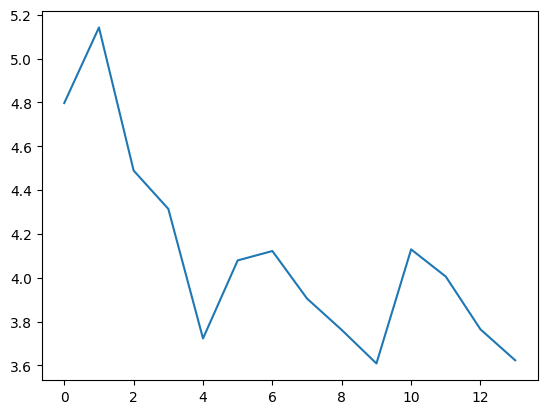

In [31]:
plt.plot(loss_history)

In [9]:
# ====================================================
# Evaluation: Text Generation
# ====================================================

model.eval()
with torch.no_grad():
    prompt = "oh Romeo! Romeo!"
    context = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    generated = context
    for _ in range(200):  # Generate 200 tokens.
        inp = generated[:, -seq_len:]
        p = model(inp)  # p: (B, seq, vocab_size)
        last_token_probs = p[:, -1, :]  # Shape: [batch_size, vocab_size]
        predicted_token = torch.multinomial(last_token_probs, num_samples=1)

        #next_token = torch.multinomial(last_token_probs, num_samples=1)
        generated = torch.cat((generated, predicted_token), dim=1)
    sample = decode(generated[0].cpu().tolist())
    print("Generated Sample:\n", sample)


Generated Sample:
 oh Romeo! Romeo! SS:
Bits.

ve is pore:
Andis, tunk rest'TESTHAwhas thern's
Ho'stecrew I cre:
To thore as ing graito ight
If un-! aS:
HEOHe my hed.

MA mallark, theo.

AMES:
I nell foruj: for brave s&NG whit,
havisen
